In this succession we will be presenting our script for tracking spermatoza. Our script is based on Trackpy V0.3.2 Package which has been developped by by Daniel Allan, Nathan Keim, Thomas Caswell and  Casper van der Wel. The package is available for downloading by this link : https://zenodo.org/record/1226458. 
Trackpy is able to track any biological samples because it performs a band pass and threshold to locate any particle. Also it uses many tools to filter the data by their appearance to eliminate undesirable data that has been track it. Our script track the spermatozoa over time and then give us the X and Y positions for each frame, to analyze their trajectory and velocity. Their are different parameters for the characterization of the tracked object, like its size and its intensity (mass), that we will use for filtering out spurious features. Following you can find the script and its explanation line by line.

#First Let implement all the package that we need for the tracking 
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pims
import trackpy as tp
import cv2
import scipy as sp
from scipy import signal

#For the figure Size
mpl.rc('figure',  figsize=(10, 6))


To start we need to upload the video that we record from the microscopy as tif file. To do so, we need the package pims that pims that read this type of files. 

In [2]:
# upload the tif file 
frames = pims.open('E:/DataSperm/iGEM 16082018/Without Nisin objective x20/sample8.tif', as_grey=True)

C:\Users\Younes\Anaconda3.1\lib\site-packages\tifffile\tifffile.py:2983: UserWarning: invalid page offset (337163640)
  warnings.warn('invalid page offset (%i)' % offset)


To get details about the video that has been upload like Length, size, and the shape of frame, and Pixel Datatype. we use the this line of code :  

In [3]:
frames

<Frames>
Source: E:/DataSperm/iGEM 16082018/Without Nisin objective x20/sample8.tif
Length: 914 frames
Frame Shape: (480, 768)
Pixel Datatype: uint8

One of the import fonction is Locate,  performe a band pass and threshold to locate only the object in any frame [0] that superior to minmass, and also select only, the object that have an average diameter in pixels, Invert Set to False or True depend on the features if they are brightest than background set it to False.

f = tp.locate(frames[0],diameter  = 17, minmass=400.0, maxsize=None, separation=50, noise_size=1, smoothing_size=None,
threshold=None, invert=False, topn=None, preprocess= True, max_iterations=10, filter_before=None, filter_after=True, 
characterize=True)
# make a new figure with a circl around the track particle for frame [0]
plt.figure(figsize=(14, 10))  
tp.annotate(f, frames[0]) 

To refine the features selected by the loacte we plot a histogram that depends on mass, to see the number of particules that selected and their mass for that we can increase or decrease to reduce the noise. We can alson change each time the minimass untils finding the best value.


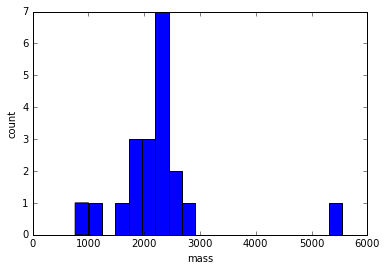

In [13]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
#label the axes.
ax.set(xlabel='mass', ylabel='count');

To locate spermatoza in each frame. We call the functiion batch, which calls locate on each frame and collects the results. It's best to set the same parameter that we used in loacte to track the same particle for all frames. 
We can reduce the number of frame or juste to track from specific frame to frame. 
all the frames	frames[:] or simply frames.
the first 10 frames	frames[:10],
the last 10 frames	frames[-10:],
a range of frames	frames[100:200],
every 10th frame	frame[::10],
a list of specific frames	frames[[100, 107, 113]].

Frame 913: 16 features


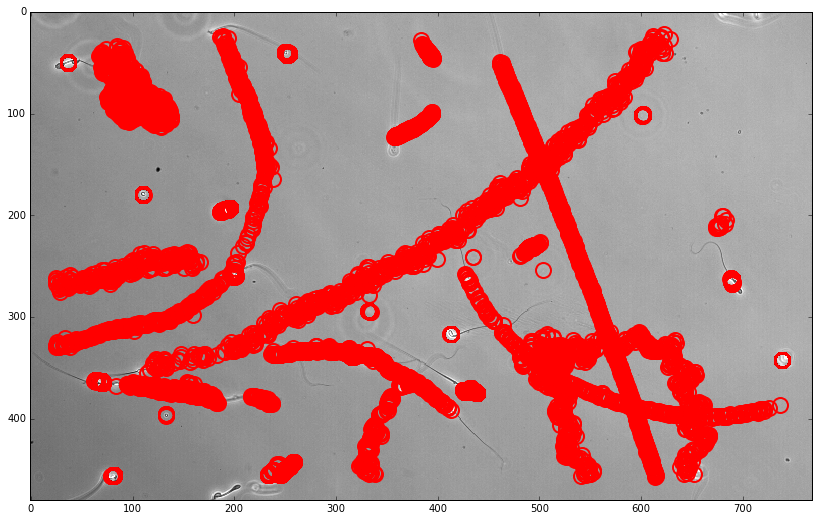

In [14]:
f = tp.batch(frames[:], 17, minmass=400.0, maxsize=None, separation=50, noise_size=1, smoothing_size=None, threshold=None,
invert=False, topn=None, preprocess= True, max_iterations=10, filter_before=None, filter_after=True,
characterize=True, engine='python')

# make a new figure
plt.figure(figsize=(14, 10))
tp.annotate(f, frames[0]);

Link function, link the same spermatozoa with the same indetintification from fram to another, and search_range is the maximu distance can move between frames in pixels,this parameeter depend on the object tracked in our cases we sit the low value as possible because our spermatoza can gone and cameback for less then 10. Memory is the number of frame we can conserve the identification if it's gone and comeback.

In [15]:
t = tp.link_df(f, search_range = 30, memory=20)

Frame 913: 16 trajectories present.


make a new figure with the trajectory for each speramtozoa, label set true to print the trajectory with their identification. Superimose the trajectory to the background we need to set the number of frame as superimpse = frames([number of the frame]).

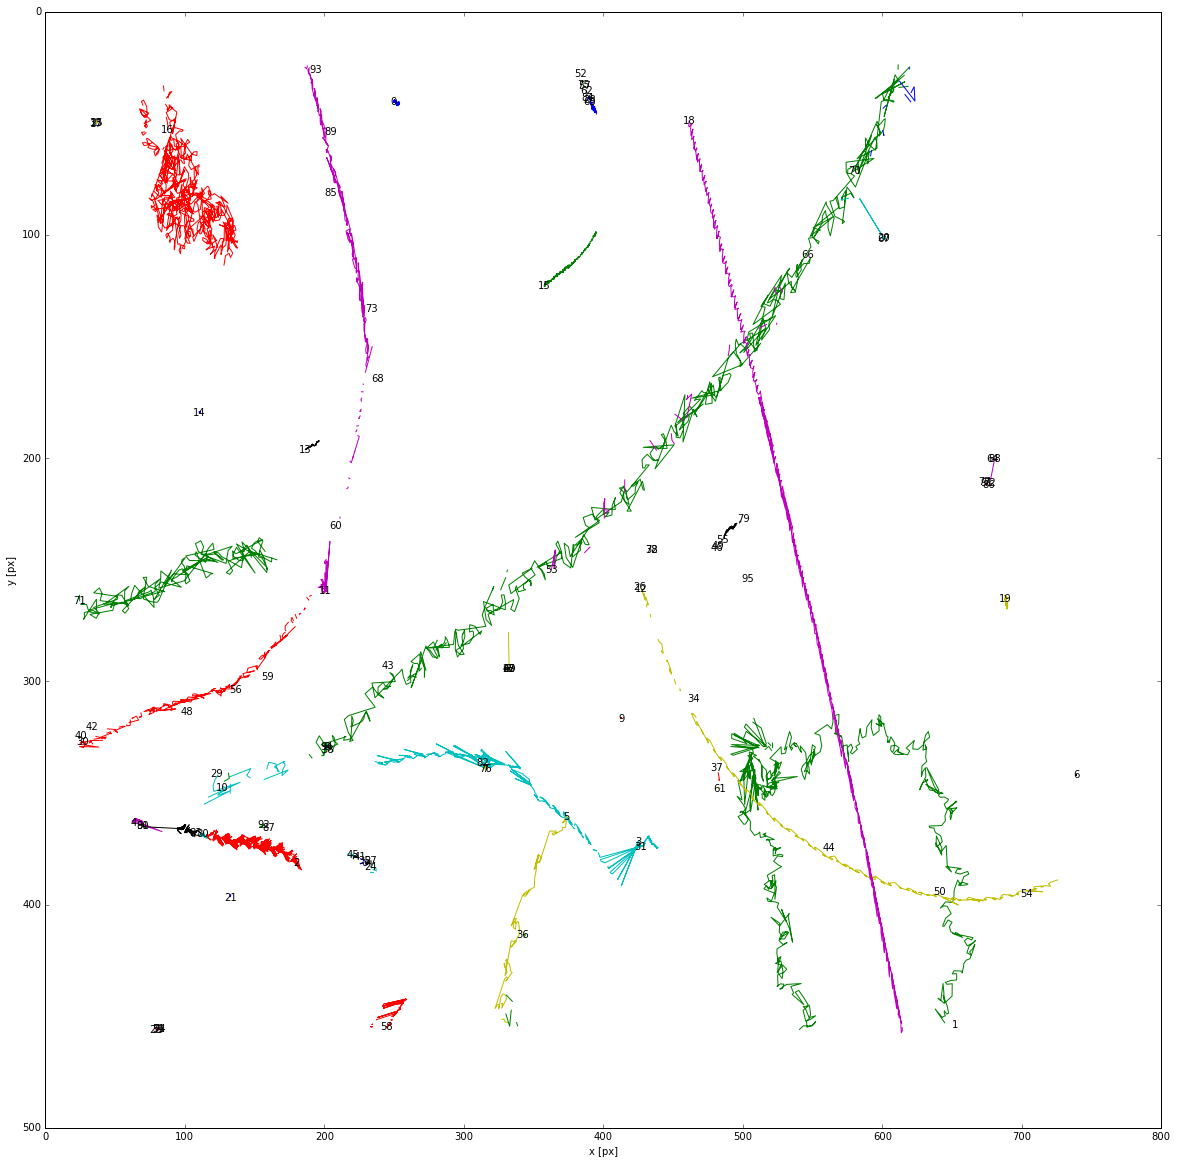

In [16]:
plt.figure(figsize=(20, 20))
tp.plot_traj(t, label=True, superimpose=None);

To filter trajectory that servive for a minimum of frames m we use the function Filter_tubs. 

In [17]:
m = 60
t1 = tp.filter_stubs(t, m) 

Compare the number of particles in the unfiltered and filtered data to keep the parametere we set before. 

In [18]:
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 96
After: 35


To print the new trajectory after the filter_stubs.

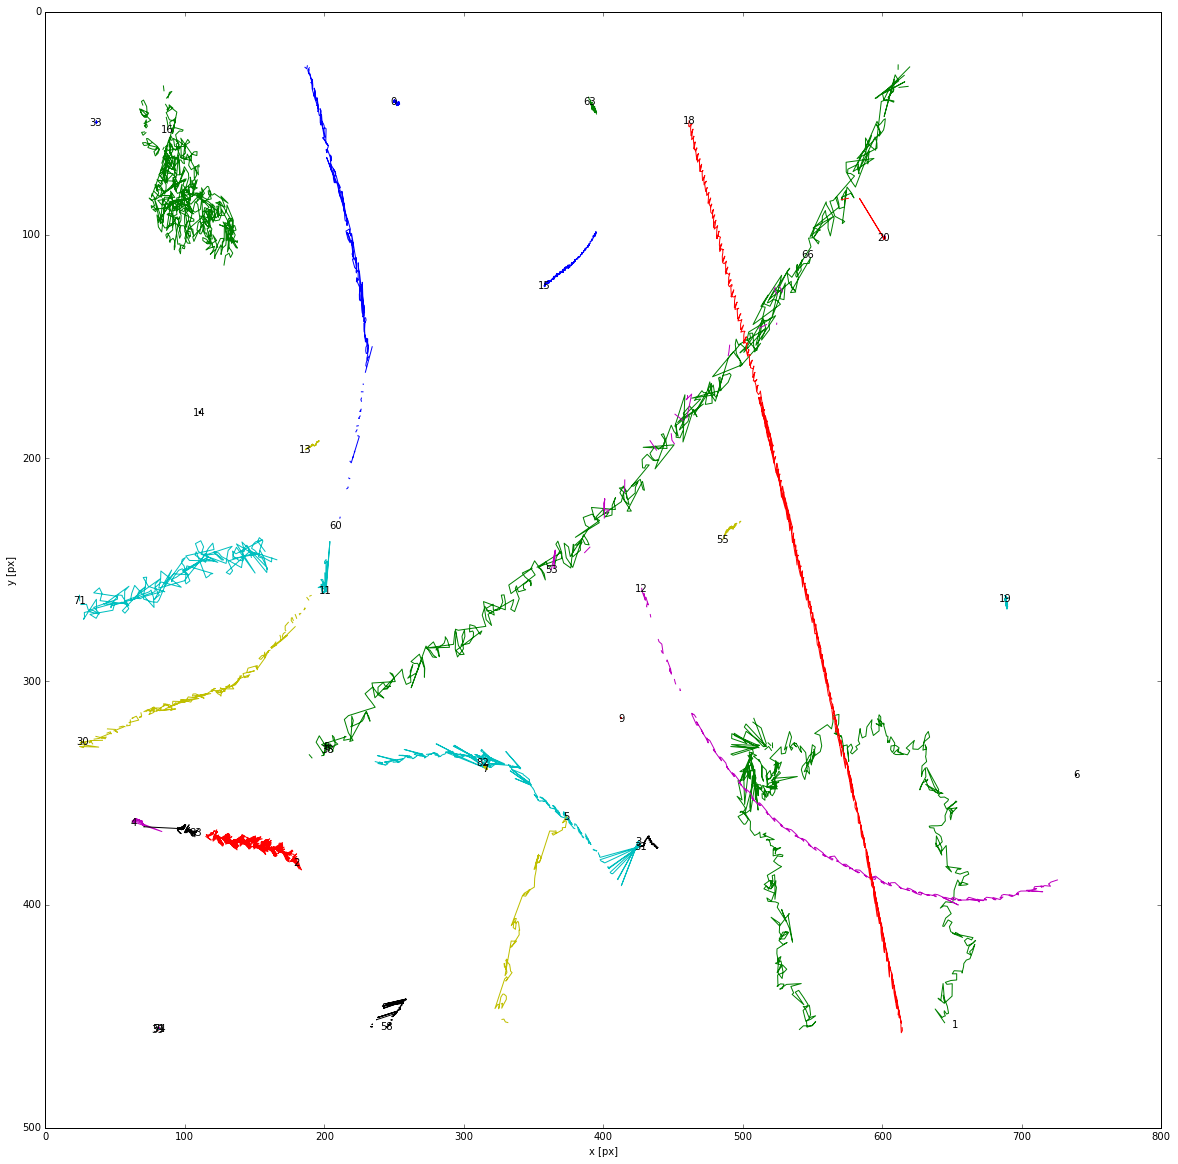

In [19]:
plt.figure(figsize=(20, 20))
tp.plot_traj(t1, label=True, superimpose=None);

We can also filter the trajectories by their appearance, throughout its trajectory.

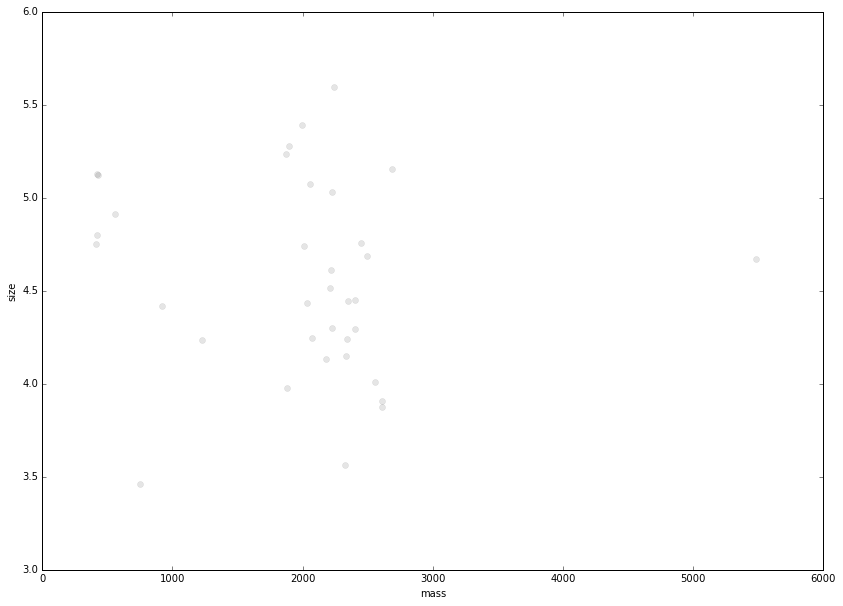

In [20]:
plt.figure(figsize=(14, 10))
tp.mass_size(t1.groupby('particle').mean()); #just plots size vs. mass

The particles with especially low mass or especially large size are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, filtering out regions of mass-size space and looking at the results using tp.annotate and tp.circle. In the end, we need to separate the good particles from the spurious ones, and it doesn't matter how we get it done.

In [21]:
t2 = t1[((t1['mass'] > 250) & (t1['size'] < 3.5) &
         (t1['ecc'] < 1.5))]

to annotate the particle that are low mass or especially large size. 

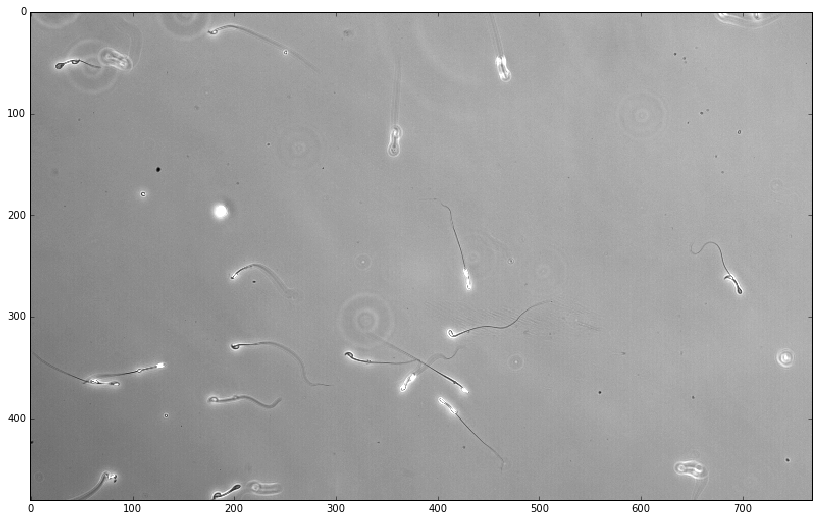

In [22]:
plt.figure(figsize=(14, 10))   
tp.annotate(t2[t2['frame'] == 0], frames[0]);

to plot the trajectory that satisfed the filtering by their low mass and size.

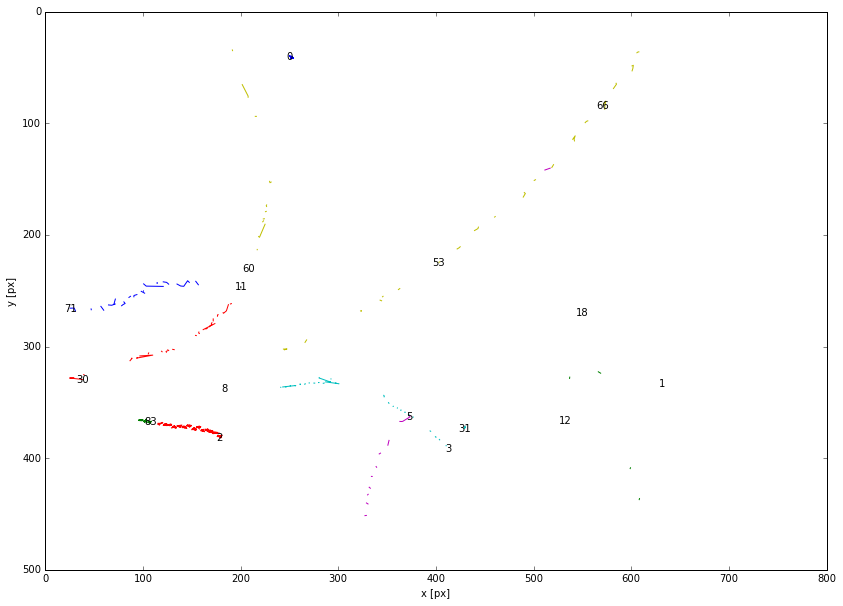

In [23]:
plt.figure(figsize=(14, 10))
tp.plot_traj(t2, label=True, superimpose=None);

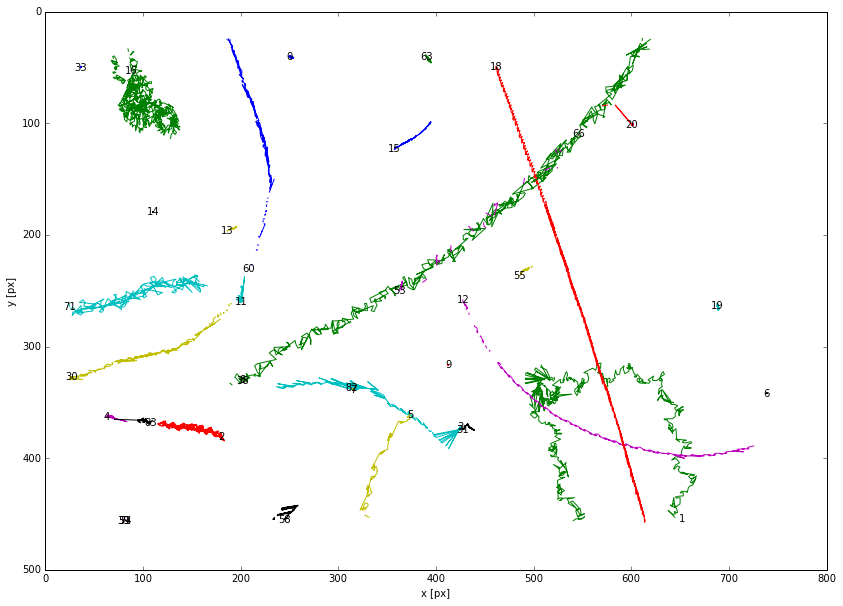

In [24]:
plt.figure(figsize=(14, 10))
tp.plot_traj(t1, label=True, superimpose=None);

if the filter of trajectory by their mass & size has not succed to delet the indiserable points we delet them manaul from the DataFrame.

In [27]:
t1.set_index('particle', drop=False, inplace=True)#we set particle as index it's the best way to delet the indiserable point.
t1.drop([0, 7, 83,], inplace = True) #inplace set to true to delet it from the t1 definetly.
t1.set_index('frame',drop=False, inplace=True ) # to return the DataFrame to default.


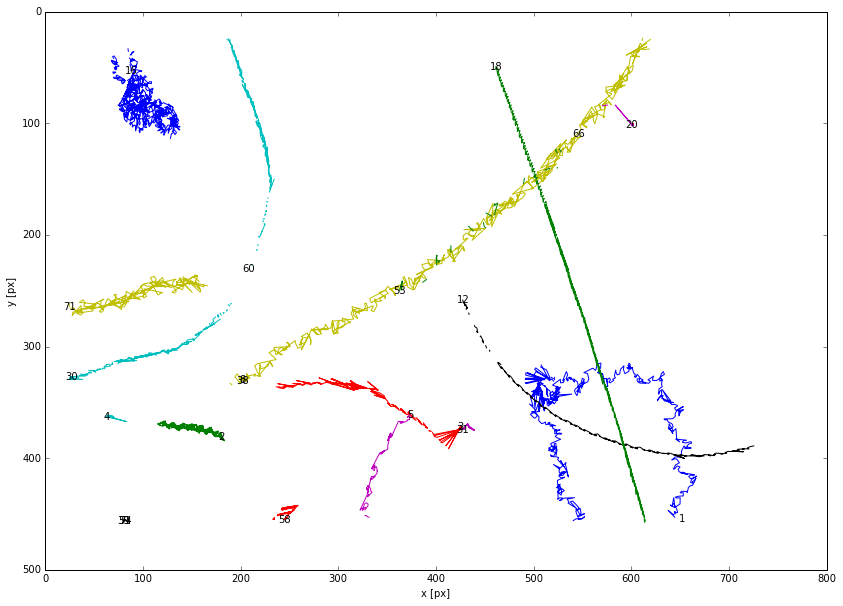

In [28]:
#to plot the news trajectory after the filtering. 
plt.figure(figsize=(14, 10))
tp.plot_traj(t1, label=True, superimpose=None);

To Combienne the trajectory manually for the same spermatozoa,after making the video of the trajectory superimpose to video, and see the different trajectory of the same spermatoza.

In [29]:
t1.replace({'particle': [30]}, 60, inplace=True)

Optionally to plot trajectory after the combination of trajectory, if you combien the same trajectory of the same spermetozoon, it will be able to print the trajectory. And see the trajectory make be the same spermatoza for all frames. if you get an error that man that you didn't combien the same trajectory of the same spermatoza, you need to run the script from the link() function, and do the same work as before.

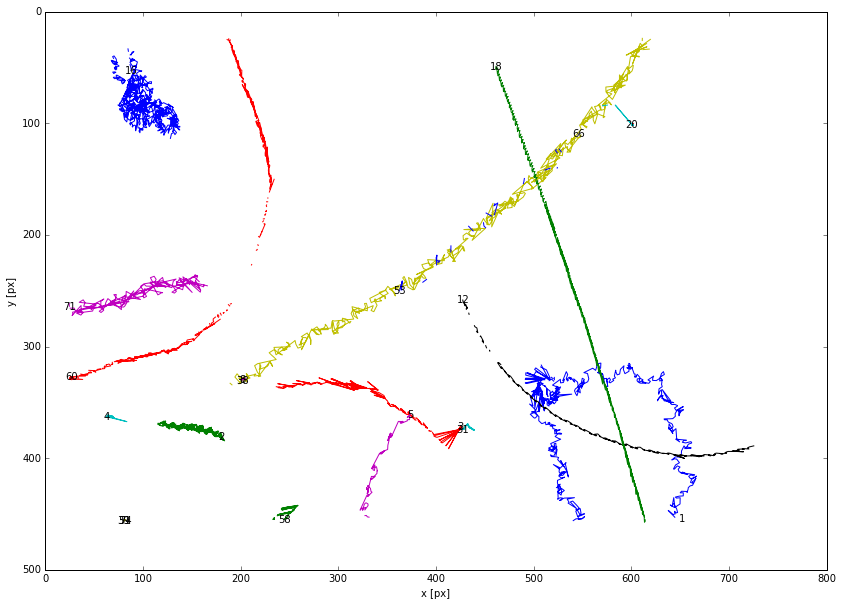

In [30]:
plt.figure(figsize=(14, 10))
tp.plot_traj(t1, label=True, superimpose=None);

to make new video with trajectory after the filtering by their apperance and the surviving time. This tools is best because we can see each spermatoza and their trajectory, and also it's useful to combine after the trajectory make by the same spermatozoa, in case the function filter_stubs(), aren't able to combine the trajectory for the same spermatoza. Or also to see the underisable particle that not corespond to spermatozoa. 

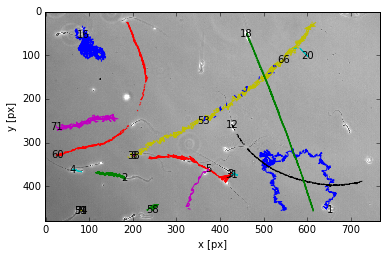

In [31]:
for i in range(1):
    fig, ax = plt.subplots()  
    tp.plot_traj(t1, label=True, superimpose=frames[i]);
    fig.savefig('C:/Users/Younes/image_{0}.png'.format(i)) #path to save the image
    
""""    
# to make the video of the trajectory 
Fps =  #rate per second to save the video it's should be the same as the video.
image_folder = 'path where the image saved '
video_name = 'path where to save the video /video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, -1, Fps, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))
    print(image)
cv2.destroyAllWindows()
video.release()
""""

To remove the drifting motion we will, compute the overall drifting motion, which we will subtract away, adopting the reference frame of the spermatozoon. 
we set the value of the smothing until to get the smooth trajectory.

In [32]:
d = tp.compute_drift(t1, smoothing  = 50)

C:\Users\Younes\Anaconda3.1\lib\site-packages\trackpy\utils.py:313: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  return df.sort_values(*args, by=by, **kwargs)
C:\Users\Younes\Anaconda3.1\lib\site-packages\trackpy\motion.py:289: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  dx = f_diff.loc[mask, pos_columns + ['frame']].groupby('frame').mean()


plot X and Y after the substract of the drift.

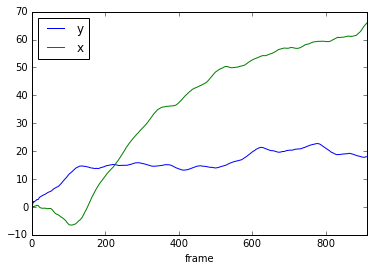

In [33]:
d.plot()

we aply the drifting substract to the DataFrame.

In [34]:
tm = tp.subtract_drift(t1.copy(), d)

we plot the trajectories after the drifiting substracting. 

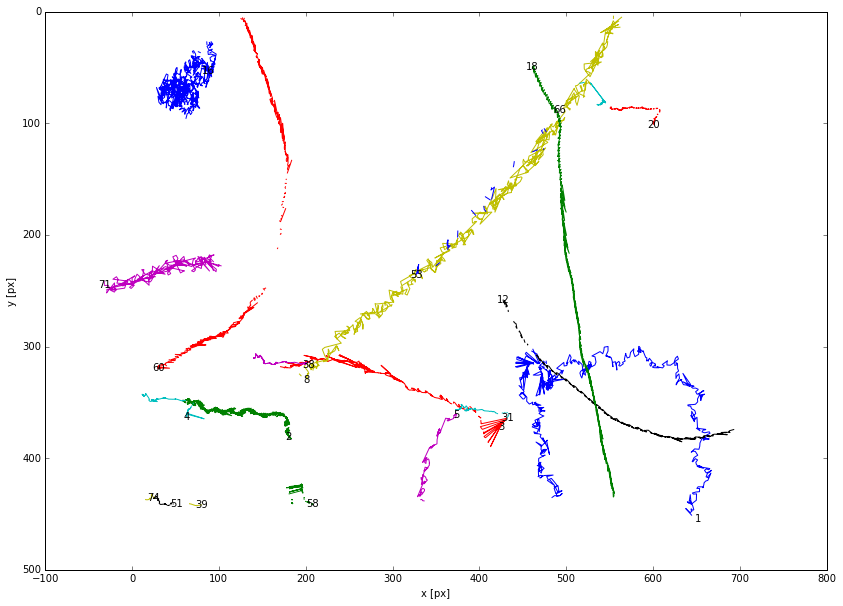

In [35]:
plt.figure(figsize=(14, 10))   
tp.plot_traj(tm,label=True)

To analyze each trajectory and get the information as the velocity and mean velocity for ploting the histogram and see the distrubtion of th mean velocity.

In [36]:
data = pd.DataFrame()
Fps = 60 #set the Number of frame per second at the video was recording. 
for item in set(tm.particle):
    sub = t1[t1.particle==item]
    dx = np.diff(sub.x)/1.  #we calculat the differnece between to frame for X postion
    dy = np.diff(sub.y)/1.  #we calculat the differnece between to frame for Y postion
    dt = np.diff(sub.frame)/Fps   #to calcul the time 
    v = ((np.sqrt(dy**2 + dx**2)))/dt   # to calcul the velocity 
    for x, y, dx, dy, v, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy), v, dt,sub.frame[:-1],):
        data = data.append([{'dx': dx, 
                             'dy': dy, 
                             'x': x,
                             'y': y,
                             'frame': frame,
                             'particle': item,
                             'dt' : dt,
                             'v' : v,
                            }])
data.head()

,dt,dx,dy,frame,particle,v,x,y
0,0.033333,9.593310,0.286408,0,1,287.927537,651.868583,453.890625
0,0.033333,2.388780,1.267579,2,1,81.127822,642.275272,454.177033
0,0.016667,6.791274,6.139421,4,1,549.299598,644.664052,452.909454
0,0.016667,5.104859,3.805608,5,1,382.036732,637.872778,446.770033
0,0.016667,0.865974,0.475856,6,1,59.286244,642.977637,450.575641


Translate DataFrame to nested_dictionary  because it's easy to manipulate the Data we get.

In [37]:
mydict = {}
for p in np.unique(data.particle):
    d = {}
    d['v'] = data.v[data.particle == p]
    d['frame'] = data.frame[data.particle == p]
    d['x'] = data.x[data.particle == p]
    d['y'] = data.y[data.particle == p]
    d['dx'] = data.dx[data.particle == p]
    d['dy'] = data.dy[data.particle == p]
    d['dt'] = data.dt[data.particle == p]
    mydict[p] = d

Plot velocities of each spermatozoa.

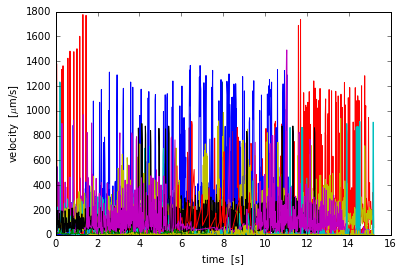

In [38]:
for p in mydict.keys():
    v_p = mydict[p]['v']   
    frame_p = mydict[p]['frame']
    t_p = frame_p/Fps
    dt = mydict[p]['dt']
    plt.plot(t_p, v_p)

plt.xlabel('time  [s]')
plt.ylabel(r'velocity  [$\mu$m/s]')
plt.show()

plot velocities with uniform filter.

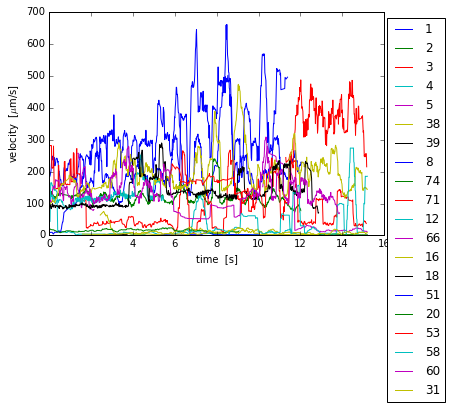

In [39]:
mean_v = []
for p in mydict.keys():
    v_p = mydict[p]['v']
    frame_p = mydict[p]['frame']
    t_p = frame_p/Fps
    #the array is filtered with uniform filter of given size.
    v_p_filtered = sp.ndimage.filters.uniform_filter1d(v_p, size = 20)
    mean_v.append(np.mean(v_p_filtered)) #add each mean velocity of each spermatoza to list mean_v
    plt.plot(t_p, v_p_filtered, label=p)
 
plt.legend(bbox_to_anchor=(1.2, 1.))
plt.xlabel('time  [s]')
plt.ylabel(r'velocity  [$\mu$m/s]')
plt.show()

To  write in a text file the data we get.

In [40]:
for i in [0]:     #Don't forget to updat the number between [] for each video :-) 
    np. savetxt ('path.txt'.format(i), mean_v)

To plot the histogram with the percentage. 

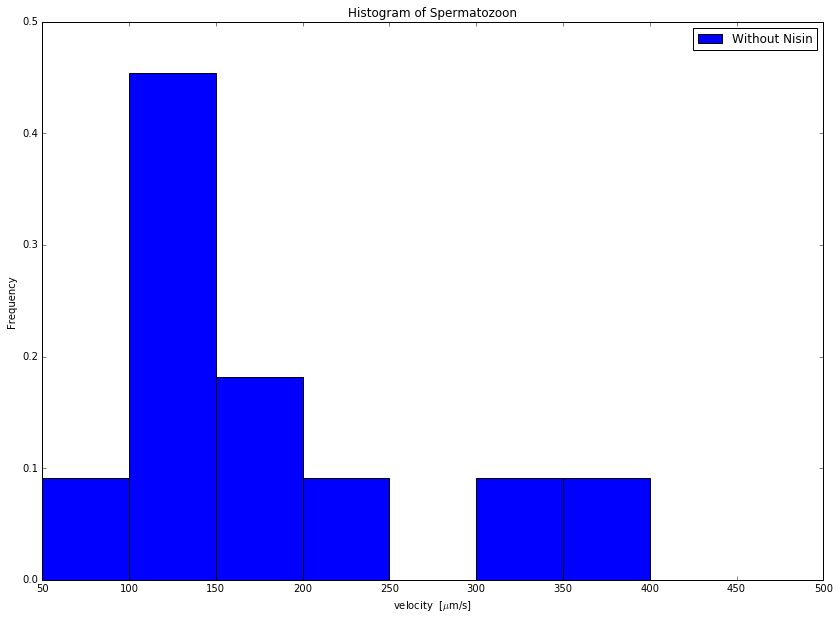

In [41]:
fig, ax = plt.subplots(figsize=(14,10))
hist, bins = np.histogram(mean_v, bins = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500])

ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='Blue', label = 'Without Nisin' )

plt.legend()
plt.ylabel('Frequency')
plt.xlabel(r'velocity  [$\mu$m/s]')
plt.title('Histogram of Spermatozoon')
plt.show()